In [1]:
import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.misc import imread, imsave
import pickle
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import concatenate, Input
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [2]:
%matplotlib inline
sns.set_context("poster")

In [3]:
X_train = []
XX_train = []
y_train = []

drives = ['driving_track_1_train_1.pkl',
         'driving_track_1_train_2.pkl',
         'driving_track_1_train_3.pkl',
         'driving_track_2_train_4.pkl',
         'driving_track_2_train_5.pkl',
         'driving_track_2_train_6.pkl']
for drive in drives:
    print('processing: ', drive)
    with open(drive, 'rb') as f:
        data = pickle.load(f)
    
    # add in the left and right version of this, not for sensor data, we just have 
    # to add it twice
    XX_train.extend(data['sensors'].astype(np.float64))
    XX_train.extend(data['sensors'].astype(np.float64))
    X_train.extend(data['images'])
    y_train.extend(data['steering_throttle'].astype(np.float64))
    X_train.extend(np.array([np.fliplr(x) for x in data['images']]))
    y_train.extend(np.negative(data['steering_throttle'].astype(np.float64)))
    
X_train = np.array(X_train)
XX_train = np.array(XX_train)[:,0:1] #only using the first var at this point
y_train = np.array(y_train)

processing:  driving_track_1_train_1.pkl
processing:  driving_track_1_train_2.pkl
processing:  driving_track_1_train_3.pkl
processing:  driving_track_2_train_4.pkl
processing:  driving_track_2_train_5.pkl
processing:  driving_track_2_train_6.pkl


In [4]:
print(X_train.shape, XX_train.shape, y_train.shape)

(112272, 80, 320, 3) (112272, 1) (112272, 2)


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


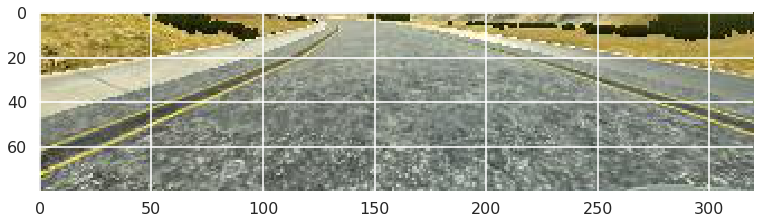

In [5]:
#view some images
plt.imshow(X_train[0])

In [21]:
def create_model():
    model = Sequential()
    
    image_input = Input(shape=(80, 320, 3), name='image_input', dtype='float32')
    sensor_input = Input(shape=(1,), name='sensor_input', dtype='float32')
    
    # preprocess
    X = Lambda(lambda x: x/255.0 - 0.5, input_shape=(80, 320, 3))(image_input)
    # conv1 layer
    X = Convolution2D(64, (5, 5))(X)
    X = MaxPooling2D((2, 2))(X)
    X = Activation('relu')(X)
    
    # conv2 layer
    X = Convolution2D(64, (5, 5))(X)
    X = MaxPooling2D((2, 2))(X)
    X = Activation('relu')(X)
    
    # conv3 layer
    X = Convolution2D(64, (3, 3))(X)
    X = MaxPooling2D((2, 2))(X)
    X = Activation('relu')(X)
    
    # conv4 layer
    X = Convolution2D(64, (3, 3))(X)
    X = MaxPooling2D((2, 2))(X)
    X = Activation('relu')(X)

    
    X = Flatten()(X) #Flatten input image
    
    #add in the speed, here we may add in other variables such 
    # as the last several throttle / speed/ steering angles, and other sensors
    X = concatenate([X, sensor_input])
    
        
    #add fully connected layers
    
    # fc1
    X = Dense(256)(X)
    X = Dropout(0.5)(X)
    X = Activation('relu')(X)
    
    # fc2
    X = Dense(128)(X)
    X = Dropout(0.5)(X)
    X = Activation('relu')(X)
    
    # fc2
    X = Dense(64)(X)
    X = Dropout(0.5)(X)
    X = Activation('relu')(X)
    
    steer_output = Dense(1, name='steer_output')(X) #output layer with 
    throttle_output = Dense(1, name='throttle_output')(X)
    #model = Model(inputs=[image_input, sensor_input], outputs=[steer_output, throttle_output])
    model = Model(inputs=[image_input, sensor_input], outputs=[steer_output])

    
    # note, setting the loss weight to favor steering
    model.compile(optimizer='adam',
              #loss={'steer_output': 'mse', 'throttle_output': 'mse'},
              loss={'steer_output': 'mse'},
              #loss_weights={'steer_output': 1., 'throttle_output': 0.2})
              loss_weights={'steer_output': 1.0})
    
    return model

In [22]:
# estimator = KerasRegressor(build_fn=lambda: model, epochs=5, shuffle=True, batch_size=128, verbose=1)
# kfold = KFold(n_splits=3)
# results = cross_val_score(estimator, X_train, y_train, cv=kfold)

# print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [23]:
model = create_model()

In [ ]:
# train the model and save it each eopch
for i in range(20):
#     model.fit([X_train, XX_train], [y_train[:,[0]], y_train[:,[1]]], shuffle=True, epochs=1, validation_split=.2, batch_size=64)
    model.fit(
        {'image_input': X_train, 'sensor_input': XX_train},
        {'steer_output': y_train[:,[0]], 'throttle_output': y_train[:,[1]]}, 
        shuffle=True, epochs=1, validation_split=.2, batch_size=64)
    
    model.save("data_model_with_speed{}.h5".format(i))
    

Train on 89817 samples, validate on 22455 samples
Epoch 1/1
89817/89817 [==============================] - 430s - loss: 0.0565 - val_loss: 0.0785
Train on 89817 samples, validate on 22455 samples
Epoch 1/1
89817/89817 [==============================] - 428s - loss: 0.0335 - val_loss: 0.0701
Train on 89817 samples, validate on 22455 samples
Epoch 1/1
89817/89817 [==============================] - 427s - loss: 0.0291 - val_loss: 0.0657
Train on 89817 samples, validate on 22455 samples
Epoch 1/1
89817/89817 [==============================] - 426s - loss: 0.0262 - val_loss: 0.0634
Train on 89817 samples, validate on 22455 samples
Epoch 1/1
89817/89817 [==============================] - 426s - loss: 0.0241 - val_loss: 0.0565
Train on 89817 samples, validate on 22455 samples
Epoch 1/1
89817/89817 [==============================] - 425s - loss: 0.0228 - val_loss: 0.0571
Train on 89817 samples, validate on 22455 samples
Epoch 1/1
89817/89817 [==============================] - 425s - loss: 0.02

KeyboardInterrupt: 

In [30]:
#loss: 0.0199 - val_loss: 0.0819